In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [29]:

# Define constants
IMAGE_WIDTH, IMAGE_HEIGHT = 128, 128  # Roboflow default size is often 416x416, but 128x128 is good for a start
BATCH_SIZE = 32
EPOCHS = 20  # You can increase this for better training
NUM_CLASSES = 6  # Unlabeled, angry, attentive, no clear emotion recognizable, relaxed, sad, uncomfortable

def create_mobilenet_model(input_shape, num_classes, fine_tune=False):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = not fine_tune  # Freeze or unfreeze the convolutional base based on fine_tune

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    model = Model(inputs, outputs)
    return model


In [30]:

def load_data(csv_file, data_dir, image_width, image_height):
    df = pd.read_csv(csv_file)
    
    # Drop the 'Unlabeled' column if it's not a class we want to predict, or if it's always 0
    # Based on the CSV content, 'Unlabeled' seems to be a class itself.
    # Let's assume all columns except 'filename' are emotion classes.
    
    class_columns = df.columns.drop('filename').tolist()
    
    # Ensure that each row has exactly one '1' for multi-class classification
    # If there are rows with multiple '1's or no '1's, this needs to be handled
    # For now, we assume it's clean one-hot encoding.
    
    # Convert the DataFrame to a format suitable for flow_from_dataframe
    # The 'y_col' should be a list of class columns
    
    # Create a list of filenames with their full paths
    df['filename'] = df['filename'].apply(lambda x: os.path.join(data_dir, x))
    
    return df, class_columns


In [31]:

def prepare_data(csv_file, data_dir, image_width, image_height, batch_size):
    df, class_columns = load_data(csv_file, data_dir, image_width, image_height)
    
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    validation_split_ratio = 0.2
    validation_samples = int(len(df) * validation_split_ratio)
    
    train_df = df.iloc[validation_samples:]
    validation_df = df.iloc[:validation_samples]
    
    num_classes = len(class_columns)
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col=class_columns,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=validation_df,
        x_col='filename',
        y_col=class_columns,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False
    )
    return train_generator, validation_generator, class_columns, num_classes


In [32]:

def build_and_compile_model(input_shape, num_classes, existing_model_path=None, fine_tune=False):
    if existing_model_path and os.path.exists(existing_model_path):
        model = tf.keras.models.load_model(existing_model_path)
        # If fine-tuning, unfreeze base model layers
        if fine_tune:
            for layer in model.layers:
                if isinstance(layer, tf.keras.Model) and layer.name.startswith('mobilenetv2'):
                    layer.trainable = True
            model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
        else:
            model.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
    else:
        model = create_mobilenet_model(input_shape, num_classes, fine_tune)
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    model.summary()
    return model


In [33]:

def train_and_save_model(model, train_generator, validation_generator, epochs, batch_size, model_save_path, early_stopping):
    history = model.fit(
        train_generator,
        steps_per_epoch=int(np.ceil(train_generator.samples / batch_size)),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int(np.ceil(validation_generator.samples / batch_size)),
        callbacks=[early_stopping]
    )
    model.save(model_save_path)
    print(f"Model trained and saved as {model_save_path}")
    return history


In [34]:

def evaluate_and_display_predictions(model_path, validation_generator, class_columns):
    loaded_model = tf.keras.models.load_model(model_path)

    validation_images, validation_labels = next(validation_generator)
    predictions = loaded_model.predict(validation_images)

    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(validation_images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(validation_images[i])
        true_label = class_columns[np.argmax(validation_labels[i])]
        # For multi-label classification with sigmoid, a threshold (e.g., 0.5) should be applied to predictions
        # to determine all present labels. For simplicity in display, we're showing the label with the highest probability.
        predicted_label = class_columns[np.argmax(predictions[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()


In [35]:

def train_model(data_dir, csv_file, model_save_path, fine_tune=False, existing_model_path=None):
    train_generator, validation_generator, class_columns, num_classes = prepare_data(
        csv_file, data_dir, IMAGE_WIDTH, IMAGE_HEIGHT, BATCH_SIZE
    )
    
    model = build_and_compile_model((IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes, existing_model_path, fine_tune)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    train_and_save_model(model, train_generator, validation_generator, EPOCHS, BATCH_SIZE, model_save_path, early_stopping)
    
    evaluate_and_display_predictions(model_save_path, validation_generator, class_columns)



--- Training with Cat Emotions.v1i.multiclass ---
Found 1657 validated image filenames.
Found 414 validated image filenames.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,917,447 (11.13 MB)

 Trainable params: 2,883,335 (11.00 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 53s 692ms/step - accuracy: 0.5232 - loss: 0.9518 - val_accuracy: 0.5386 - val_loss: 1.2037
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 684ms/step - accuracy: 0.6005 - loss: 0.6573 - val_accuracy: 0.5580 - val_loss: 1.0637
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 675ms/step - accuracy: 0.6301 - loss: 0.4987 - val_accuracy: 0.5725 - val_loss: 0.7086
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 668ms/step - accuracy: 0.6222 - loss: 0.4023 - val_accuracy: 0.5652 - val_loss: 0.8860
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 670ms/step - accuracy: 0.6385 - loss: 0.3381 - val_accuracy: 0.5604 - val_loss: 0.5483
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 668ms/step - accuracy: 0.6699 - loss: 0.2924 - val_accuracy: 0.6063 - val_loss: 0.5019
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 668ms/step - accuracy: 0.6614 - loss: 0.2717 - val_accuracy: 0.5821 - val_loss: 0.6518
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 665ms/step - accuracy: 0.6741 - loss: 0.2500 - val_accu

Model trained and saved as cat_emotion_mobilenet_model_v1.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


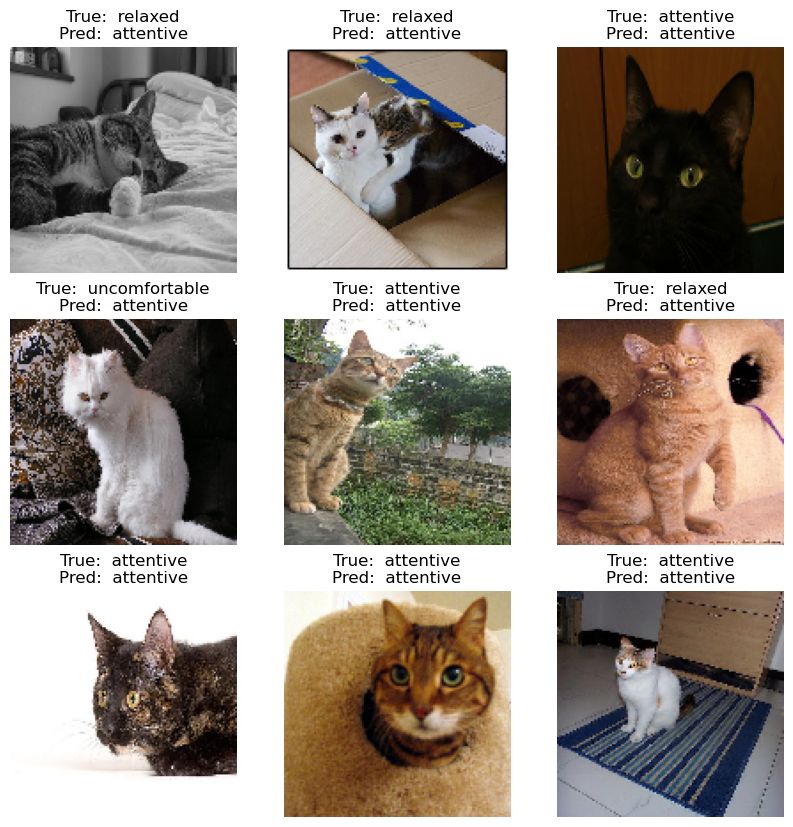

In [36]:

if __name__ == "__main__":
    # Define paths for both datasets
    DATA_DIR_V1 = "/home/qod120/Documents/project/2nd_ai_web_project/ai_model/Cat Emotions.v1i.multiclass/train"
    CSV_FILE_V1 = os.path.join(DATA_DIR_V1, "_classes.csv")
    MODEL_SAVE_PATH_V1 = "cat_emotion_mobilenet_model_v1.h5"

    print("\n--- Training with Cat Emotions.v1i.multiclass ---")
    train_model(DATA_DIR_V1, CSV_FILE_V1, MODEL_SAVE_PATH_V1, fine_tune=False, existing_model_path=None)
